<a href="https://colab.research.google.com/github/moskalt/DLnotebooks/blob/main/cifar10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

In [3]:
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['automobile', 'airplane', 'deer', 'frog', 'cat', 'bird', 'horse', 'dog', 'truck', 'ship']


In [6]:
frogs = os.listdir(data_dir + '/train' + '/frog')
print(frogs[:10])
print("Count of images: ", len(frogs))

['4270.png', '1558.png', '1047.png', '0404.png', '0298.png', '1545.png', '4742.png', '4266.png', '0230.png', '2473.png']
Count of images:  5000


In [7]:
dogs = os.listdir(data_dir + '/train' + '/dog')
print(dogs[:10])
print("Count of images: ", len(dogs))
dogs_test = os.listdir(data_dir + '/test' + '/dog')
print("Count of images: ", len(dogs_test))
#every train and test folders has same amount of pictures

['4270.png', '1558.png', '1047.png', '0404.png', '0298.png', '1545.png', '4742.png', '4266.png', '0230.png', '2473.png']
Count of images:  5000
Count of images:  1000


In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
train_dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [10]:
image, label = train_dataset[0]
print(image.shape, label)


torch.Size([3, 32, 32]) 0


In [11]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:
def show_image(image, label):
    print('Label: ', train_dataset.classes[label], "{}".format(label))
    plt.imshow(image.permute(1,2,0))

Label:  airplane 0


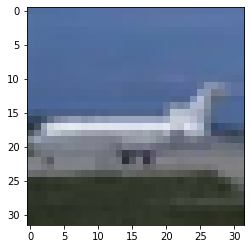

In [14]:
show_image(*train_dataset[256])

In [15]:
#seed for random split
random_seed = 1561
torch.manual_seed(random_seed);

In [16]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset,[train_size, val_size])
len(train_dataset), len(train_ds), len(val_ds)

(50000, 45000, 5000)

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [18]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [19]:
from torchvision.utils import  make_grid

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

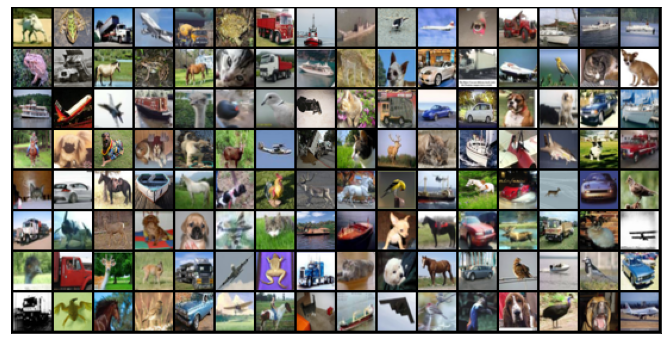

In [20]:
show_batch(train_dl)

In [21]:
import torch.nn as nn
import torch.nn.functional as F
#simple kernel for conv layer

In [22]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [23]:
for images, labels in train_dl:
    print('input shape: ', images.shape)
    out = simple_model(images)
    print('out shape: ', out.shape)
    break

input shape:  torch.Size([128, 3, 32, 32])
out shape:  torch.Size([128, 8, 16, 16])


In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss.detach(), 'val_acc' : acc}

    def validation_epoch_end(seld, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    


In [25]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [26]:
model = Cifar10CnnModel()

In [27]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([1024, 4096])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [28]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [29]:
#make sure we have expected output
for images, labels in train_dl:
    print("input shape: ", images.shape)
    out = model(images)
    print('out images: ', out.shape)
    print('out[0]: ', out[0])
    break

input shape:  torch.Size([128, 3, 32, 32])
out images:  torch.Size([128, 10])
out[0]:  tensor([ 0.0248,  0.0441,  0.0384,  0.0361,  0.0069, -0.0365, -0.0233,  0.0415,
        -0.0349, -0.0233], grad_fn=<SelectBackward>)


In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model,device);

In [33]:

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_function = torch.optim.SGD):
    history = []
    optimizer = opt_function(model.parameters(), lr)
    for epoch in range(epochs):
        #training
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
model = to_device(Cifar10CnnModel(), device)

In [35]:
evaluate(model, val_dl)

{'val_acc': 0.09991957247257233, 'val_loss': 2.302781820297241}

In [36]:
#first try
num_epochs = 9
opt_func = torch.optim.Adam
lr = 0.003

In [37]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8184, val_loss: 1.4924, val_acc: 0.4435
Epoch [1], train_loss: 1.3790, val_loss: 1.2839, val_acc: 0.5305
Epoch [2], train_loss: 1.1700, val_loss: 1.1026, val_acc: 0.5976
Epoch [3], train_loss: 1.0322, val_loss: 1.0750, val_acc: 0.6162
Epoch [4], train_loss: 0.9390, val_loss: 1.0745, val_acc: 0.6250
Epoch [5], train_loss: 0.8566, val_loss: 0.9749, val_acc: 0.6585
Epoch [6], train_loss: 0.7791, val_loss: 0.9588, val_acc: 0.6753
Epoch [7], train_loss: 0.7150, val_loss: 0.9828, val_acc: 0.6610
Epoch [8], train_loss: 0.6473, val_loss: 0.9548, val_acc: 0.6803


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

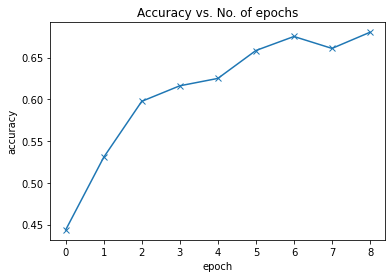

In [39]:
plot_accuracies(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

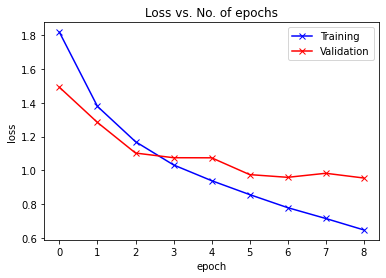

In [41]:
plot_losses(history)

In [42]:
#model is overfitted

In [43]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [44]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


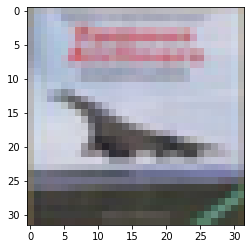

In [45]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


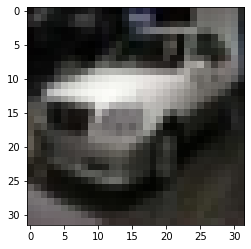

In [47]:
img, label = test_dataset[1546]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


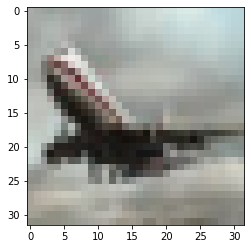

In [48]:
img, label = test_dataset[654]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


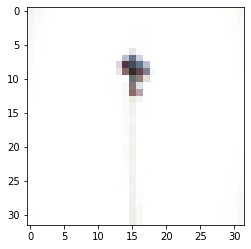

In [49]:
img, label = test_dataset[342]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: cat , Predicted: bird


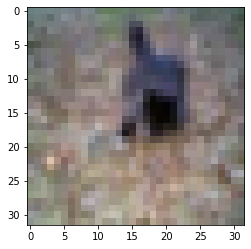

In [52]:
img, label = test_dataset[3233]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


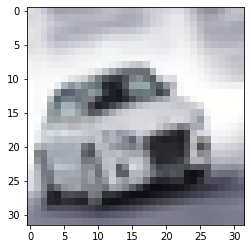

In [53]:
img, label = test_dataset[1231]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

seems like our cnn have no problems to recognize automobiles

In [54]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result


{'val_acc': 0.68017578125, 'val_loss': 0.9732078909873962}

In [55]:
#saving model

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [59]:
model_save_name = 'cnn_cifar10_classifier.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
torch.save(model.state_dict(),path)